# 2 - Labelling view datasets with pretrained model

In this tutorial, we will work with a view dataset that we created in the previous tutorial, and label that with web-image trained models. Lots of the code in this notebook is just going to be boilerplate to use our pretrained models as label extractors, but the core idea is that we are taking a "view dataset", defined in the previous tutorial as a combination of RGB, depth, and confidence information, and convert that to point-wise dataset that contains the XYZ position of a point, a semantic encoding of the label of whatever is at that point, and a vision-language model (aka CLIP) embedding of whatever object is at that point.

Conceretely, the dataset we create will have a `__getitem__` method that returns a dictionary with the following keys:
```python
{
    "xyz": torch.Tensor, # (3,) tensor of XYZ position of point
    "rgb": torch.Tensor, # (3,) tensor of RGB color of point
    "label": torch.Tensor, # (1,) tensor ID of semantic label of point
    "instance": torch.Tensor, # (1,) tensor ID of instance label of point, if exists, else -1
    "img_idx": torch.Tensor, # (1,) tensor ID of image that point was sampled from, or the bounding box that this point is a part of.
    "distance": torch.Tensor, # (1,) tensor of distance from point to camera
    "clip_vector": torch.Tensor, # (512,) or (768,), tensor of CLIP-text or Sentence-BERT embedding of point
    "clip_image_vector": torch.Tensor, # (512,) or (768,), tensor of CLIP-image embedding of point
    "semantic_weight": torch.Tensor, # (1,) tensor of weight of semantic label of point; generally the confidence of the semantic label coming from the detector.
}
```

Since this class uses a lot of boilerplate code, we are not reproducing it here, but you can find the code for our pretrained model based labeller in `dataloaders/real_dataset.py`

In [1]:
import sys
sys.path.append('..')

import torch
from dataloaders import R3DSemanticDataset, DeticDenseLabelledDataset

# Load the dataset
# If you are following up after tutorial 1
dataset = torch.load("../nyu_views.pth")
# Otherwise, create from scratch.
# dataset = R3DSemanticDataset("../nyu.r3d")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
labelled_dataset = DeticDenseLabelledDataset(
    dataset, 
    use_extra_classes=False, 
    exclude_gt_images=False, 
    use_lseg=False, 
    subsample_prob=0.01, 
    visualize_results=True, 
    detic_threshold=0.4,
    visualization_path="detic_labelled_results",
)

INFO - 2022-10-11 00:40:21,835 - SentenceTransformer - Load pretrained SentenceTransformer: all-mpnet-base-v2
INFO - 2022-10-11 00:40:22,482 - SentenceTransformer - Use pytorch device: cuda
INFO - 2022-10-11 00:40:25,605 - checkpoint - [Checkpointer] Loading from https://dl.fbaipublicfiles.com/detic/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth ...
INFO - 2022-10-11 00:40:25,606 - file_io - URL https://dl.fbaipublicfiles.com/detic/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth cached in /home/mahi/.torch/iopath_cache/detic/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth


Loading pretrained CLIP


Calculating Detic features: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 757/757 [04:34<00:00,  2.76it/s]


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

## Visualizing the labelling

We can visualize the labelling with our web-image models by setting the `visualize_results=True` and `visualization_path` to a desired path, as seen in the above cell. This step is incredibly useful for debugging, and can help you understand what the model is doing. We have found that the downstream training can sometimes be suboptimal if the initial labelling is not that great. In this case, we can use the visualization to understand what the model is doing, and then if necessary, modify the set of to be more accurate.

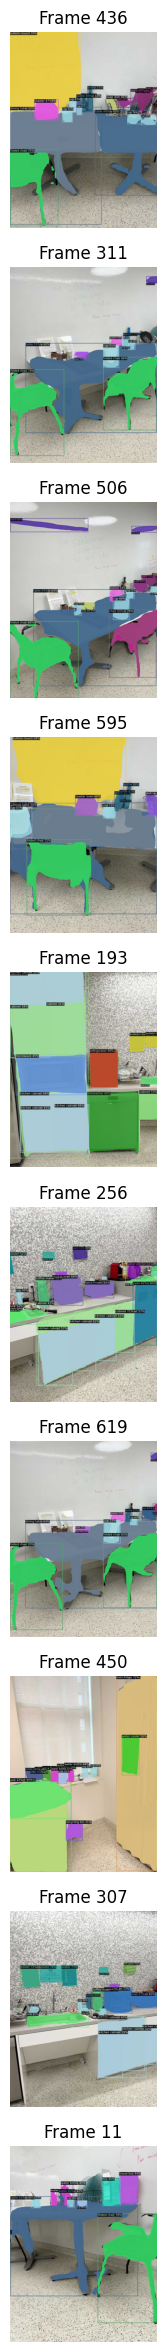

In [3]:
import glob
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

NUM_IMAGES = 10
TOTAL_FRAMES = glob.glob("detic_labelled_results/*.jpg")
fig, axes = plt.subplots(NUM_IMAGES, 1, figsize=(3, 3 * NUM_IMAGES))

for ax, data in zip(axes, range(NUM_IMAGES)):
    random_index = np.random.randint(0, len(TOTAL_FRAMES))
    ax.imshow(Image.open(TOTAL_FRAMES[random_index]))
    ax.axis("off")
    ax.set_title(f"Frame {random_index}")

## Save the dataloader

Finally, we save the dataloader so that we can use it on our next step for training.

In [5]:
torch.save(labelled_dataset, "../detic_labeled_dataset.pt")